In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
trainDf=pd.read_csv("train.csv")
print(trainDf.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

In [3]:
print(trainDf.shape)

(42000, 785)


In [4]:
ytrain=trainDf["label"].values
X_train=trainDf.iloc[:,1:].values.reshape(-1,28,28)
X_train=X_train.astype(np.float32)/255.0
print(f"Size of y_train : {len(ytrain)}\nSize of X_train : {X_train.shape}\n")

Size of y_train : 42000
Size of X_train : (42000, 28, 28)



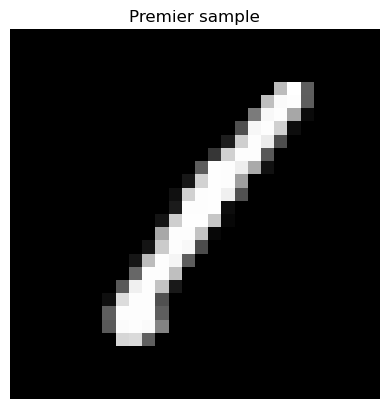

In [5]:
plt.imshow(X_train[0],cmap="gray")
plt.title("Premier sample")
plt.axis("off")
plt.show()

In [6]:
sobelX=np.array([
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
]) #detection de bords horizontaux

sobelY=np.array([
    [-1,-2,-1],
    [0,0,0],
    [1,2,1]
]) #detection de bords verticaux

prewittX=np.array([
    [-1,0,1],
    [-1,0,1],
    [-1,0,1]
]) #detection de bords horizontaux (comme sobelX mais moins marqué)

laplacien=np.array([
    [0,-1,0],
    [-1,4,-1],
    [0,-1,0]
]) #detection de bords toutes directions

laplacienPlus=np.array([
    [-1,-1,-1],
    [-1,8,-1],
    [-1,-1,-1]
]) #detection de bords toutes directions (laplacien plus marqué)

blur=np.array([
    [1/9,1/9,1/9],
    [1/9,1/9,1/9],
    [1/9,1/9,1/9]
]) #flou

gaussien=np.array([
    [1/16,2/16,1/16],
    [2/16,4/16,2/16],
    [1/16,2/16,1/16]
]) #flou plus doux

sharpen=np.array([
    [0,-1,0],
    [-1,5,-1],
    [0,-1,0]
]) #accentuation contours


avrPooling2dKernel=np.array([
    [1/4,1/4],
    [1/4,1/4]
]) #Fait la moyenne des 4 éléments = avrPooling de dim 2,2

In [7]:
def padding(img,pad_size=0):
    if pad_size==0:
        return img
    else:
        newImg=np.zeros((img.shape[0]+2*pad_size,img.shape[1]+2*pad_size))
        for w in range(pad_size,newImg.shape[0]-pad_size):
            for h in range(pad_size,newImg.shape[1]-pad_size):
                newImg[w][h]=img[w-pad_size][h-pad_size]
        return newImg

In [8]:
def createRandomKernels(nb_kernels,dim):
    kernels=[]
    for i in range(nb_kernels):
        kernels.append(np.random.randn(dim[0],dim[1]))
    return kernels

In [9]:
def maxPooling2d(images,dim):
    maxed=[]
    for img in images:
        newImg=np.zeros((((img.shape[0]-dim[0])//dim[0])+1,((img.shape[1]-dim[1])//dim[1])+1))
        for w in range(newImg.shape[0]):
            for h in range(newImg.shape[1]):
                cur_max=float("-inf")
                for kw in range(dim[0]):
                    for kh in range(dim[1]):
                        if img[w*dim[0]+kw][h*dim[1]+kh]>cur_max:
                            cur_max=img[w*dim[0]+kw][h*dim[1]+kh]
                newImg[w][h]=cur_max
        maxed.append(newImg)
    return maxed

In [10]:
def averagePooling2d(images,dim):
    averaged=[]
    for img in images:
        newImg=np.zeros((((img.shape[0]-dim[0])//dim[0])+1,((img.shape[1]-dim[1])//dim[1])+1))
        for w in range(newImg.shape[0]):
            for h in range(newImg.shape[1]):
                avr=0
                for kw in range(dim[0]):
                    for kh in range(dim[1]):
                        avr+=img[w*dim[0]+kw][h*dim[1]+kh]
                newImg[w][h]=avr/(dim[0]*dim[1])
        averaged.append(newImg)
    return averaged

In [11]:
def conv2d(inputs,out_dim,kernel_size,pad_size=0,stride=1,specificKernel=None,extractKernels=False):
    outputs=[]
    kernels=[]
    padded=[]
    for img in inputs:
        padded.append(padding(img,pad_size=pad_size))
    for resultante in range(out_dim):
        if specificKernel is not None:
            if len(specificKernel)!=len(inputs):
                if len(specificKernel)>len(inputs):
                    k=specificKernel[:len(inputs)]
                else:
                    k=specificKernel*(len(inputs)//len(specificKernel))+specificKernel[:len(inputs)%len(specificKernel)]
            else:
                k=specificKernel
        else:
            k=createRandomKernels(len(inputs),kernel_size)
        kernels.append(k)

        newImg=np.zeros((((padded[0].shape[0]-kernel_size[0])//stride)+1,((padded[0].shape[1]-kernel_size[1])//stride)+1))

        for w in range(newImg.shape[0]):
            for h in range(newImg.shape[1]):
                res=0
                for kw in range(kernel_size[0]):
                    for kh in range(kernel_size[1]):
                        tot=0
                        for i,img in enumerate(padded):
                            tot+=k[i][kw][kh]*img[w*stride+kw][h*stride+kh]
                        res+=tot
                newImg[w][h]=res

        outputs.append(newImg)
    
    if extractKernels:
        return outputs,kernels
    return outputs

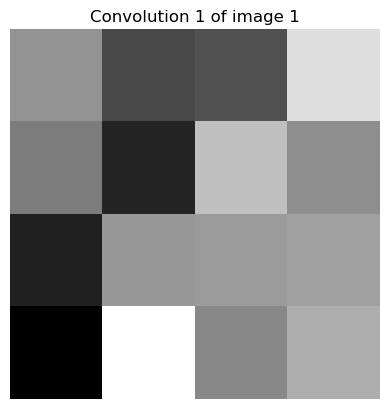

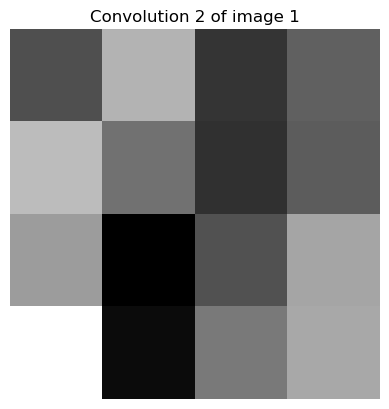

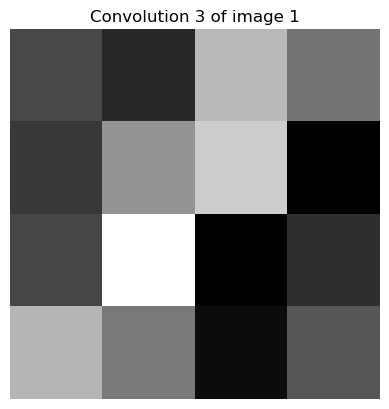

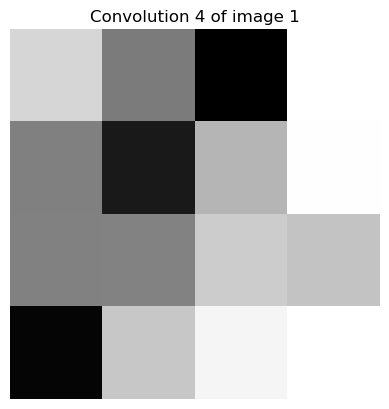

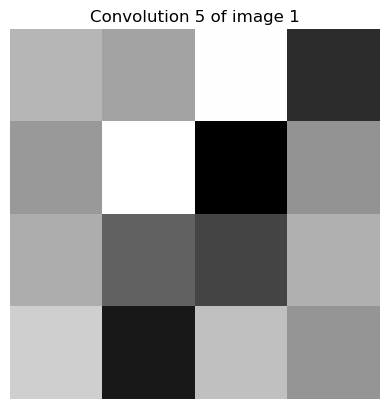

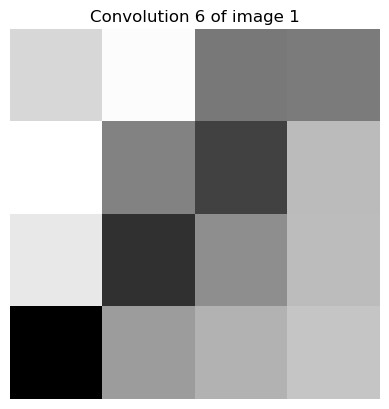

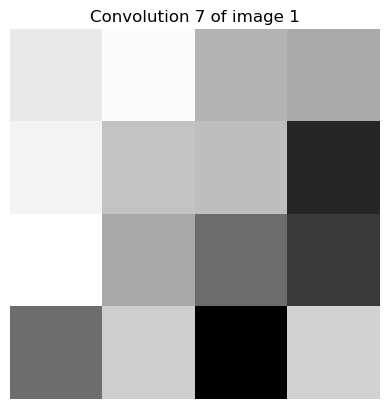

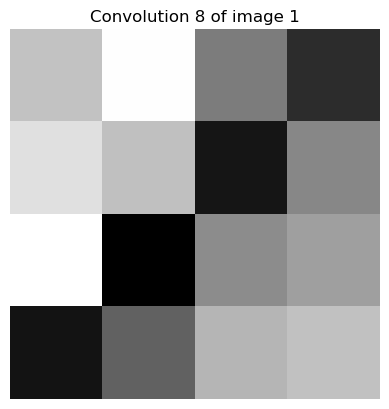

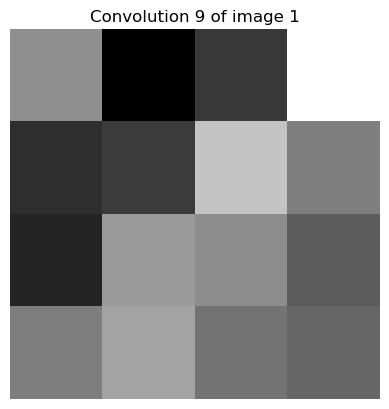

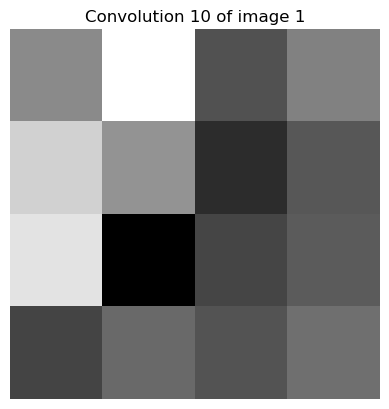

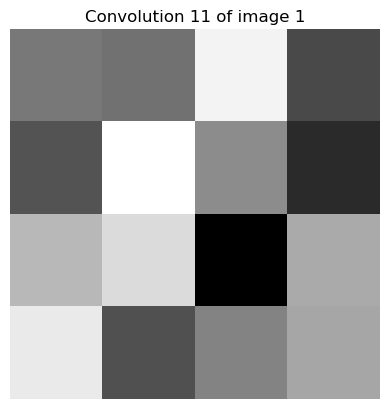

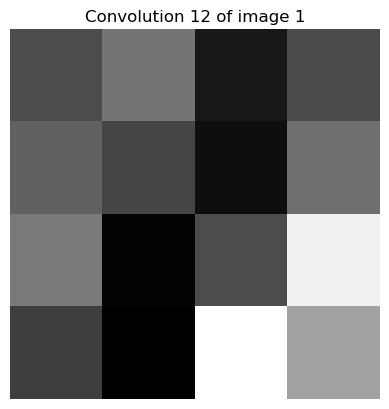

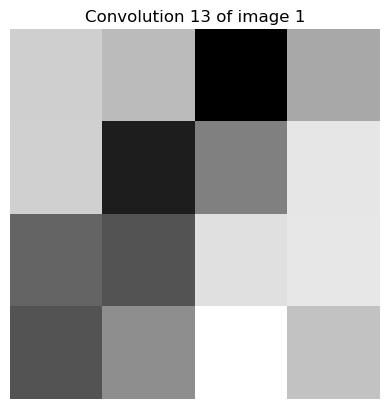

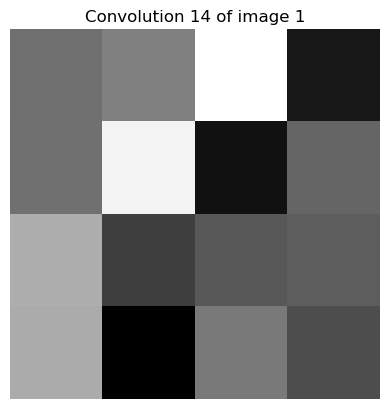

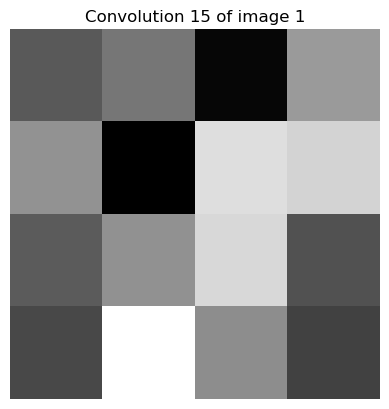

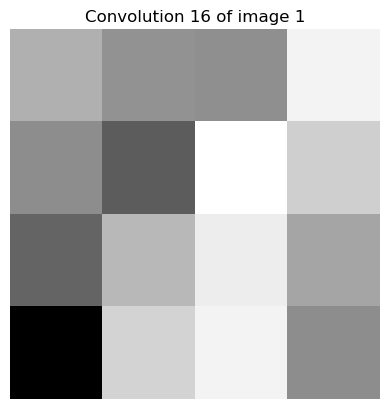

In [65]:
kernels=[sobelX,sobelY,prewittX,laplacien,laplacienPlus,blur,gaussien,sharpen]
#si je veux passer une image BGR il faut d'abord la passer en gris ou séparer les cannaux en plusieurs images
images=X_train[:20000]
conv1=[]
for img in images:
    conv=(conv2d([img],6,(5,5),pad_size=0))
    avr=averagePooling2d(conv,(2,2))
    conv2=conv2d(avr,16,(5,5),pad_size=0)
    avr2=averagePooling2d(conv2,(2,2))
    conv1.append(avr2)
for i in range(1):
    for m in range(len(conv1[i])):
        plt.imshow(conv1[i][m],cmap="gray")
        plt.title(f"Convolution {m+1} of image {i+1}")
        plt.axis("off")
        plt.show()

In [66]:
flat=[]
for i in range(len(conv1)):
    fla=[]
    for convs in conv1[i]:
        fla.append(convs.flatten())
    ca=np.concatenate(fla)
    flat.append(ca)
flat=np.array(flat)

In [57]:
print(flat.shape)

(100, 256)


In [15]:
def createRandomBias(nb_neurones):
    bias=np.random.randn(nb_neurones)
    return bias

In [16]:
def createRandomWeights(nb_inputs,nb_neurones):
    limit=np.sqrt(6/(nb_inputs+nb_neurones))
    weights=np.random.uniform(-limit,limit,size=(nb_neurones,nb_inputs))
    return weights

In [177]:
def denseLayer(inputs,nb_neurones,fonctionActivation=None,specificBias=None,specificWeights=None,returnWeightsAndBias=False,alpha=0.01):
    bias=[]
    weights=[]
    outputs=[]
    if specificBias is None:
        bias=createRandomBias(nb_neurones)
    elif len(specificBias)==nb_neurones:
        bias=specificBias
    else:
        print(f"Erreur : le nombre de biais assigné ({len(specificBias)}) n'est pas équivalent au nombre de neurones : {nb_neurones}")
    if specificWeights is None:
        weights=createRandomWeights(len(inputs),nb_neurones)
    elif len(specificWeights)==nb_neurones and len(specificWeights[0])==len(inputs):
        weights=specificWeights
    else:
        print(f"Erreur : le nombre de poids assigné n'est pas correct : {len(specificWeights)} pour {nb_neurones} neurones et {len(specificWeights[0])} pour {len(inputs)} inputs.")
    for neurone in range(nb_neurones):
        result=0
        for inpu in range(len(inputs)):
            result+=(inputs[inpu]*weights[neurone][inpu])
        result+=bias[neurone]
        if fonctionActivation=="ReLU":
            result=max(0,result)
        if fonctionActivation=="Leaky ReLU":
            if result<0:
                result=alpha*result
        if fonctionActivation=="Sigmoid":
            result=(1/(1+np.exp(-result)))
        if fonctionActivation=="Tanh":
            result=((np.exp(result)-np.exp(-result))/(np.exp(result)+np.exp(-result)))
        outputs.append(result)
    outputs=np.array(outputs)
    if fonctionActivation=="Softmax":
        exps=np.exp(outputs-np.max(outputs))
        outputs=exps/np.sum(exps)
    if returnWeightsAndBias:
        return outputs,weights,bias
    return outputs

In [18]:
test=np.random.randn(3)
print(test)
outputs=denseLayer(test,2,fonctionActivation="Leaky ReLU")
print(outputs)
outputs2=denseLayer(outputs,3,fonctionActivation="Softmax")
print(outputs2)

[0.09457448 0.99119689 0.21047844]
[-0.00808581  0.30425281]
[0.30725566 0.01211821 0.68062613]


In [58]:
y_train=[]
for y in range(len(ytrain)):
    yt=np.zeros(10)
    yt[ytrain[y]]=1
    y_train.append(yt)

In [20]:
print(y_train[0])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [67]:
weights1,bias1=createRandomWeights(256,128),createRandomBias(128)
weights2,bias2=createRandomWeights(128,84),createRandomBias(84)
weights3,bias3=createRandomWeights(84,10),createRandomBias(10)
f1="ReLU"
f2="ReLU"
#256 -> 128 -> 84 -> 10
def forward(inputs,weights1,bias1,weights2,bias2,weights3,bias3,f1,f2):
    outputs1,outputs2,outputs3=[],[],[]
    for i,inp in enumerate(inputs):
        outputs1.append(denseLayer(inp,128,fonctionActivation=f1,specificBias=bias1,specificWeights=weights1))
        outputs2.append(denseLayer(outputs1[i],84,fonctionActivation=f2,specificBias=bias2,specificWeights=weights2))
        outputs3.append(denseLayer(outputs2[i],10,fonctionActivation="Softmax",specificBias=bias3,specificWeights=weights3))
    return outputs1,outputs2,outputs3

outputs1,outputs2,outputs3=forward(flat,weights1,bias1,weights2,bias2,weights3,bias3,f1,f2)

print(outputs3[0])
print(outputs3[1])

[1.77505483e-04 1.37800191e-05 2.80721165e-04 1.11897287e-03
 3.63420209e-06 2.29136021e-12 1.74602333e-04 9.98230741e-01
 3.97857600e-08 3.10910798e-09]
[3.67133010e-20 6.49432533e-20 4.90552531e-03 6.71110004e-03
 3.24912467e-08 6.05471128e-21 1.11395755e-04 9.88271946e-01
 1.83851184e-20 9.76534852e-34]


In [61]:
MSE=[]
for out in range(len(outputs3)):
    MSE.append((np.sum((outputs3[out]-y_train[out])**2))/10)
print(MSE[0])

0.1999853005728788


In [40]:
#DMSE/DWx = DMSE/DYx * DYx/DZx * DZx/DWx pour les poids entre la dernière couche et la couche de sortie
#fonction d'activation : Softmax
#on fait 84 -> 10 donc chaque output a 84 poids connectés à elle
#DMSE/Dweights3[0][0] -> pour actualier le premier poids, celui entre le premier neurone de la couche précédente et la première output.
#= DMSE/Doutputs3[0] (Doutputs3[0] = softmax(Z0)+bias3[0]) * Doutputs3[0]/DZ[0] * DZ[0]/Dweights3[0][0] Z[0] = a0*weights3[0][0]+a0*weights3[0][1]+...+bias[0], 
#a0 étant l'output du premier neurone de la couche précédente et bias3 le biais du premier neurone.
#Ainsi MSE=(1/10)*SOMME((outputs3-y_train[0])**2) = 1/10 * ((outputs3[0]-y_train[0][0])²+(outputs3[0]-y_train[0][0])²+...) donc DMSE/Doutputs3[0] = 1/10 * 2 * 1 * (outputs3[0]-y_train[0][0])
#Doutputs3[0]/DZ[0] = Dsoftmax(Z0)/DZ0 -> softmax(Z0) = exp(Z0)/SOMME0->n(exp(Zn)) Dsoftmax(Z0)/DZ0 est de la forme (U/V)' donc = (exp(Z0)*(SOMME)-exp(Z0)²)/SOMME² = exp(Z0)*(SOMME-exp(Z0))/SOMME²
#sachant que outputs3[0]=exp(Z0)/SOMME alors Dsoftmax(Z0)/DZ0= outputs3[0]*((SOMME/SOMME)-(exp(Z0)/SOMME)) = outputs3[0]*(1-outputs3[0]) = outputes3[0] - outputs3[0]**2
#enfin, DZ0/Dweights3[0][0]= D(outputs2[0]*weights3[0][0]+outputs2[0]*weights3[0][1]...)/Dweights3[0][0] = outputs2[0]
#en conclusion: DMSE/Dweights3[0][0]=1/5 * (outputs3[0]-y_train[0][0]) * (outputs3[0]-outputs3[0]**2) * outputs2[0]
#et pour actualiser weights3[0][1] : 1/5 * (outputs3[0]-y_train[0][0]) * (outputs3[0]-outputs3[0]**2) * outputs2[1] jusqu'à outputs2[83] pour weights3[0][83]
#pour weights3[1][0] : 1/5 * (outputs3[1]-y_train[0][1]) * (outputs3[1]-outputs3[1]**2) * outputs2[0] etc...
#pour weights2[0][0]: (1/5 * (outputs3[1]-y_train[0][1]) * (outputs3[1]-outputs3[1]**2)+1/5 * (outputs3[2]-y_train[0][2]) * (outputs3[2]-outputs3[2]**2)...)* Da/Dz-1

def backPropagation(flat,outputs1,outputs2,outputs3,weights1,weights2,weights3,bias1,bias2,bias3,alpha=0.001,f1="ReLU",f2="ReLU"):
    gradSoft=np.zeros(outputs3[0].shape[0])
    gradB3=np.zeros(outputs3[0].shape[0])
    gradB2=np.zeros(outputs2[0].shape[0])
    gradB1=np.zeros(outputs1[0].shape[0])
    gradW3=np.zeros(weights3.shape)
    gradWeights3=np.zeros(weights3.shape)
    gradW2=np.zeros(weights2.shape)
    gradWeights2=np.zeros(weights2.shape)
    gradW1=np.zeros(weights1.shape)
    gradWeights1=np.zeros(weights1.shape)
    for img in range(len(outputs3)):
        gradA2=np.zeros(outputs2[img].shape[0])
        gradA1=np.zeros(outputs1[img].shape[0])
        gradMSE=(2/len(outputs3[img]))*(outputs3[img]-y_train[0])
        gradSoft=gradMSE*outputs3[img]*(1-outputs3[img])
        for out3 in range(len(outputs3[img])): #chaque neurone de sortie (10)
            for out2 in range(len(outputs2[img])): #chaque output précédent
                gradWeights3[out3][out2]=gradSoft[out3]*outputs2[img][out2]
        
        for out2 in range(len(outputs2[img])):
            for out3 in range(len(outputs3[img])):
                if f2=="ReLU":
                    if outputs2[img][out2]>0:
                        gradA2[out2]+=gradSoft[out3]*weights3[out3][out2]
                    else:
                        gradA2[out2]+=0
        
        for out2 in range(len(outputs2[img])):
            for out1 in range(len(outputs1[img])):
                gradWeights2[out2][out1]=gradA2[out2]*outputs1[img][out1]
        
        for out1 in range(len(outputs1[img])):
            for out2 in range(len(outputs2[img])):
                if f1=="ReLU":
                    if outputs1[img][out1]>0:
                        gradA1[out1]+=gradA2[out2]*weights2[out2][out1]
                    else:
                        gradA1[out1]+=0
        
        for out1 in range(len(outputs1[img])):
            for fla in range(len(flat[img])):
                gradWeights1[out1][fla]=gradA1[out1]*flat[img][fla]

        gradW1+=gradWeights1/len(outputs3)
        gradB1+=gradA1/len(outputs3)
        gradW2+=gradWeights2/len(outputs3)
        gradB2+=gradA2/len(outputs3)
        gradB3+=gradSoft/len(outputs3)
        gradW3+=gradWeights3/len(outputs3)

    newWeights3=weights3-alpha*gradW3
    newWeights2=weights2-alpha*gradW2
    newWeights1=weights1-alpha*gradW1
    newBias3=bias3-alpha*gradB3
    newBias2=bias2-alpha*gradB2
    newBias1=bias1-alpha*gradB1

    return newWeights1,newBias1,newWeights2,newBias2,newWeights3,newBias3

In [ ]:
newWeights1,newBias1,newWeights2,newBias2,newWeights3,newBias3=backPropagation(flat,outputs1,outputs2,outputs3,weights1,weights2,weights3,bias1,bias2,bias3,alpha=0.001,f1="ReLU",f2="ReLU")

In [35]:
print(f"Old weight : {weights1[0][0]} , new : {newWeights1[0][0]}")

Old weight : 0.07393104184753962 , new : 0.07393104246500314


In [197]:
def training(nb_epoch,inputs,y_label,weights1,bias1,weights2,bias2,weights3,bias3,f1,f2):
    for e in range(nb_epoch-1):
        outputs1,outputs2,outputs3=forward(inputs,weights1,bias1,weights2,bias2,weights3,bias3,f1,f2)
        MSE=[]
        for out in range(len(outputs3)):
            MSE.append((np.sum((outputs3[out]-y_label[out])**2))/10)
        print(f"epoch : {e+1} : {np.sum(MSE)}")
        weights1,bias1,weights2,bias2,weights3,bias3=backPropagation(inputs,outputs1,outputs2,outputs3,weights1,weights2,weights3,bias1,bias2,bias3,alpha=0.001,f1="ReLU",f2="ReLU")

    outputs1,outputs2,outputs3=forward(inputs,weights1,bias1,weights2,bias2,weights3,bias3,f1,f2)
    MSE=[]
    for out in range(len(outputs3)):
        MSE.append((np.sum((outputs3[out]-y_label[out])**2))/10)
    print(f"Last MSE : {np.sum(MSE)}")
    return weights1,bias1,weights2,bias2,weights3,bias3


In [93]:
testInputs=np.zeros((100,10))
y_testput=np.zeros((100,10))
print(testInputs[0])
for i in range(100):
    testInputs[i][i%10]=1
    y_testput[i][i%10]=1
print(testInputs[0],y_testput[0])
print(testInputs[1],y_testput[1])
MSE=[]
for out in range(len(testInputs)):
    MSE.append((np.sum((testInputs[out]-y_testput[out])**2))/10)
print(np.sum(MSE))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0


In [ ]:
print(testInputs[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [195]:
fixedtestweights1,fixedtestbias1=createRandomWeights(10,128),createRandomBias(128)
fixedtestweights2,fixedtestbias2=createRandomWeights(128,84),createRandomBias(84)
fixedtestweights3,fixedtestbias3=createRandomWeights(84,10),createRandomBias(10)

In [207]:
inp=testInputs[:4]
testweights1,testbias1,testweights2,testbias2,testweights3,testbias3=training(400,inp,y_testput,fixedtestweights1,fixedtestbias1,fixedtestweights2,fixedtestbias2,fixedtestweights3,fixedtestbias3,f1,f2)
testoutputs1,testoutputs2,testoutputs3=forward(testInputs,testweights1,testbias1,testweights2,testbias2,testweights3,testbias3,f1,f2)

epoch : 1 : 0.47823213554743416
epoch : 2 : 0.4780985943883376
epoch : 3 : 0.47796506982156717
epoch : 4 : 0.4778315603644379
epoch : 5 : 0.47769806454029184
epoch : 6 : 0.4775645808784783
epoch : 7 : 0.47743110791433435
epoch : 8 : 0.47729764418916776
epoch : 9 : 0.4771641882502386
epoch : 10 : 0.4770307386507442
epoch : 11 : 0.4768972939498034
epoch : 12 : 0.476763852712442
epoch : 13 : 0.4766304135095798
epoch : 14 : 0.47649697491801823
epoch : 15 : 0.4763635355204285
epoch : 16 : 0.47623009390534166
epoch : 17 : 0.47609664866713886
epoch : 18 : 0.4759631984060429
epoch : 19 : 0.47582974172811104
epoch : 20 : 0.4756962772452282
epoch : 21 : 0.47556280357510194
epoch : 22 : 0.47542931934125787
epoch : 23 : 0.4752958231730366
epoch : 24 : 0.47516231370559114
epoch : 25 : 0.47502878957988603
epoch : 26 : 0.47489524944269706
epoch : 27 : 0.4747616919466125
epoch : 28 : 0.47462811575003494
epoch : 29 : 0.4744945195171847
epoch : 30 : 0.4743609019181041
epoch : 31 : 0.47422726162866263
ep

In [205]:
print(testoutputs3[0])
print(testoutputs3[1])

[0.01907207 0.36789635 0.00663615 0.01714597 0.00529372 0.17743199
 0.00412876 0.19102508 0.08186727 0.12950263]
[0.01635277 0.27520553 0.00834847 0.01253903 0.00564357 0.19505236
 0.00433768 0.25465981 0.08271057 0.14515021]


In [198]:
true=0
for out in range(len(inp)):
    print(f"Pred : {np.argmax(testoutputs3[out])}, reel : {np.argmax(y_testput[out])}")
    if np.argmax(testoutputs3[out])==np.argmax(y_testput[out]):
        true+=1
print(true)

Pred : 1, reel : 0
Pred : 1, reel : 1
Pred : 1, reel : 2
Pred : 1, reel : 3
1
